In [1]:
import cv2 
import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report
import numpy as np 

In [2]:
from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person= 100, color= True)  # resize = 0.5,

classes = lfw_people.target_names
classes = classes.tolist()
print("n_classes : ", len(classes))
print(classes)

n_classes :  5
['Colin Powell', 'Donald Rumsfeld', 'George W Bush', 'Gerhard Schroeder', 'Tony Blair']


In [3]:
lfw_people.target.shape

(1140,)

In [4]:
lfw_people.images.shape

(1140, 62, 47, 3)

(1140, 62, 47)


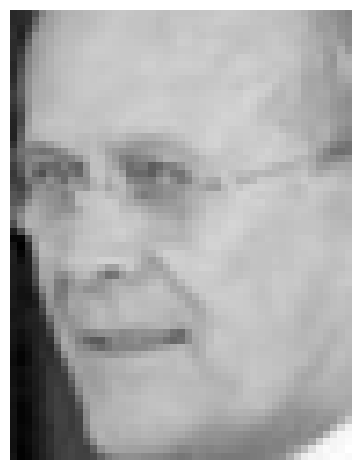

In [5]:
# feature extractor
sift = cv2.SIFT_create()

def computekeypointsanddescriptors(extractor,image):
    kp,desc = extractor.detectAndCompute(image, None)
    return kp,desc

images = []
labels = []
for i in range(lfw_people.images.shape[0]):
    img = lfw_people.images[i]
    label = lfw_people.target[i]
    imgs = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    imgs = cv2.normalize(imgs, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    images.append(imgs)
    labels.append(label)
images = np.array(images)
labels = np.array(labels)
print(images.shape)
plt.imshow(images[9],cmap ='gray')
plt.axis('off')
plt.tight_layout()

In [6]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size= 0.2, random_state = 1000, shuffle = True)
x_test.shape

(228, 62, 47)

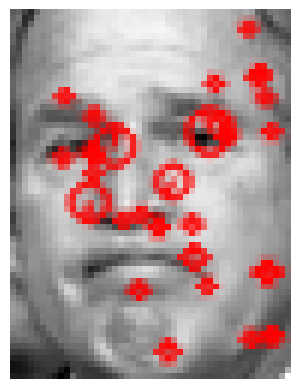

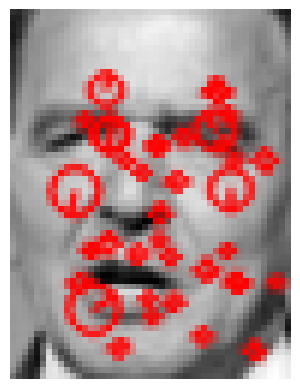

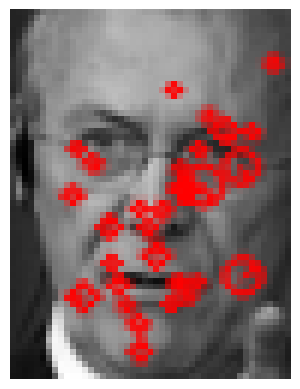

In [7]:
keypoints = [] 
descriptors = [] 
for img in x_train:
    img_kp, img_desc = computekeypointsanddescriptors(sift, img)    # extract keypoints and descriptors for each image
    keypoints.append(img_kp)
    descriptors.append(img_desc)         

for i in range(3):
    out = cv2.drawKeypoints(images[i], keypoints[i], 0, (255, 0, 0),
                                 flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(out,cmap ='gray')
    plt.axis('off')
    plt.show()   

In [8]:
# set numpy seed for reproducability
np.random.seed(0)

all_descriptors = []
for desc in descriptors:
    # extract specific descriptor within the image
    for descriptr in desc:
        all_descriptors.append(descriptr)

# convert to single numpy array
all_descriptors = np.stack(all_descriptors)
all_descriptors.shape

(33800, 128)

In [9]:
# Dictionary/Vocabulary construction 

from scipy.cluster.vq import kmeans,vq

k= 500
iters = 1
voc, variance = kmeans(all_descriptors, k , iters)          # generates codebook centroid(code book) and mean_value

# creating histogram of training images
#visual_words = []
#for img_desc in descriptors:
#    img_visual_words, dist = vq(img_desc, voc)
#    visual_words.append(img_visual_words)

# visual word look like for image 0
#visual_words[0][:5], len(visual_words[0])

In [10]:
# Vector quantization

im_features=np.zeros((len(x_train),k),"float32")
for i in range(len(x_train)):
    words,distance=vq(descriptors[i],voc)
    for w in words:
        im_features[i][w]+=1

In [11]:
# visual word look like for image 0
im_features[10][:12], len(im_features[10])

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), 500)

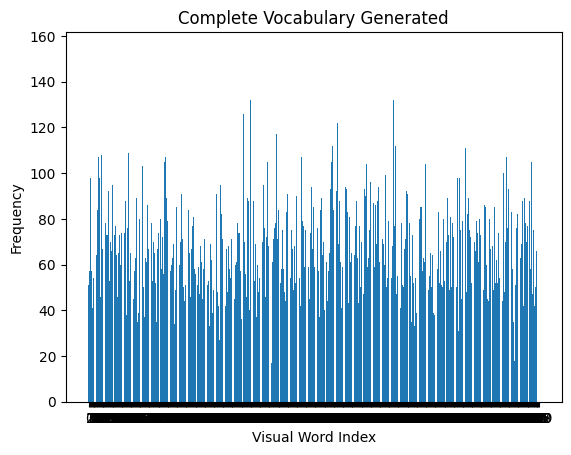

In [12]:
def plot_histogram(features,k):
    x_scalar = np.arange(k)
    y_scalar = np.array([abs(np.sum(features[:,h], dtype=np.int32)) for h in range(k)])

    plt.bar(x_scalar, y_scalar)
    plt.xlabel("Visual Word Index")
    plt.ylabel("Frequency")
    plt.title("Complete Vocabulary Generated")
    plt.xticks(x_scalar + 0.4, x_scalar)
    plt.show()
plot_histogram(im_features, k)

In [13]:
#Preprocessing 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
im_features= scaler.fit_transform(im_features)

In [14]:
# creating a classification model
from sklearn.svm import SVC
from scipy.stats import loguniform

param_grid = {
    "C":  [0.01, 0.1, 1, 10, 100, 1000], 
    "gamma": loguniform(1e-4, 1e-1),
}
clf = RandomizedSearchCV(
    SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=10
)
clf = clf.fit(im_features, np.array(y_train))

print(clf.best_estimator_)

SVC(C=1, class_weight='balanced', gamma=0.0003457507914543043)


Accuracy on training data : 0.9298245614035088
                   precision    recall  f1-score   support

     Colin Powell       0.99      0.94      0.96       187
  Donald Rumsfeld       0.91      0.92      0.91        98
    George W Bush       0.98      0.91      0.94       425
Gerhard Schroeder       0.84      0.98      0.90        86
       Tony Blair       0.79      0.97      0.87       116

         accuracy                           0.93       912
        macro avg       0.90      0.94      0.92       912
     weighted avg       0.94      0.93      0.93       912



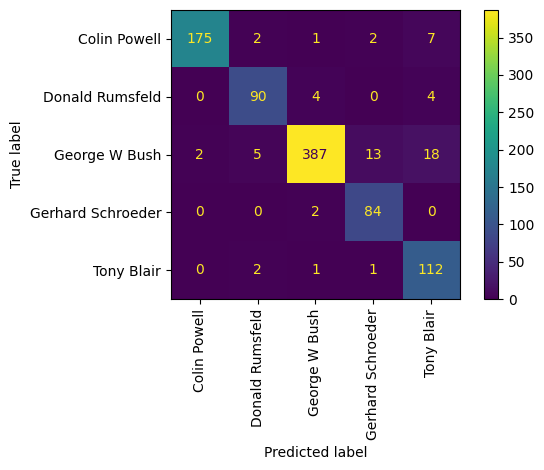

In [15]:
# Training accuracy
preds = clf.predict(im_features)
acc = accuracy_score(y_train,preds)
print("Accuracy on training data :", acc)

print(classification_report(y_train, preds, target_names=classes))
ConfusionMatrixDisplay.from_estimator(
    clf, im_features, y_train, display_labels=classes, xticks_rotation="vertical"
)
plt.tight_layout()
plt.show()
#confusion_matrix(y_train, preds, labels = classes)

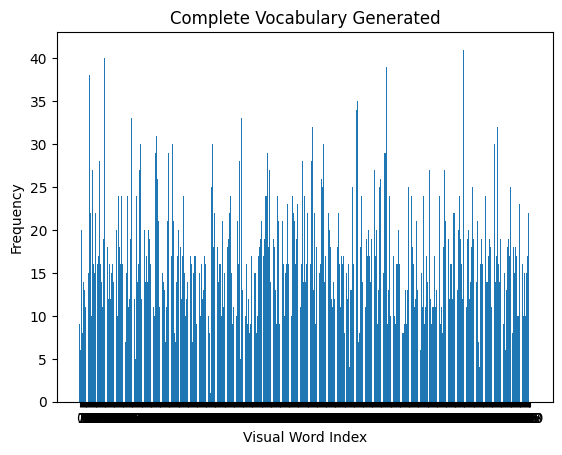

In [16]:
kp= []
descrip = []
for test_img in x_test:
    kps,descs = computekeypointsanddescriptors(sift, test_img)
    kp.append(kps)
    descrip.append(descs)

test_features=np.zeros((len(x_test),k),"float32")
for i in range(len(x_test)):
    words,distance=vq(descrip[i],voc)
    for w in words:
        test_features[i][w]+=1
plot_histogram(test_features, k)

test_features = scaler.transform(test_features)

Accuracy on test data:  0.8026315789473685
                   precision    recall  f1-score   support

     Colin Powell       0.92      0.73      0.82        49
  Donald Rumsfeld       1.00      0.74      0.85        23
    George W Bush       0.87      0.90      0.88       105
Gerhard Schroeder       0.65      0.65      0.65        23
       Tony Blair       0.51      0.75      0.61        28

         accuracy                           0.80       228
        macro avg       0.79      0.75      0.76       228
     weighted avg       0.83      0.80      0.81       228



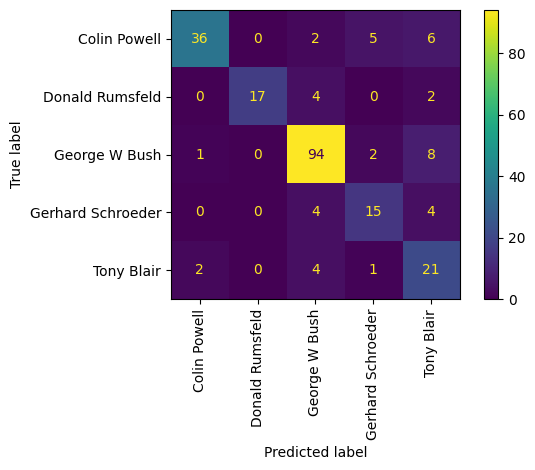

In [17]:
predicted = clf.predict(test_features)
ACC = accuracy_score(y_test, predicted)
print("Accuracy on test data: ",ACC)

print(classification_report(y_test, predicted, target_names=classes))
ConfusionMatrixDisplay.from_estimator(
    clf, test_features, y_test, display_labels=classes, xticks_rotation="vertical"
)
plt.tight_layout()
plt.show()

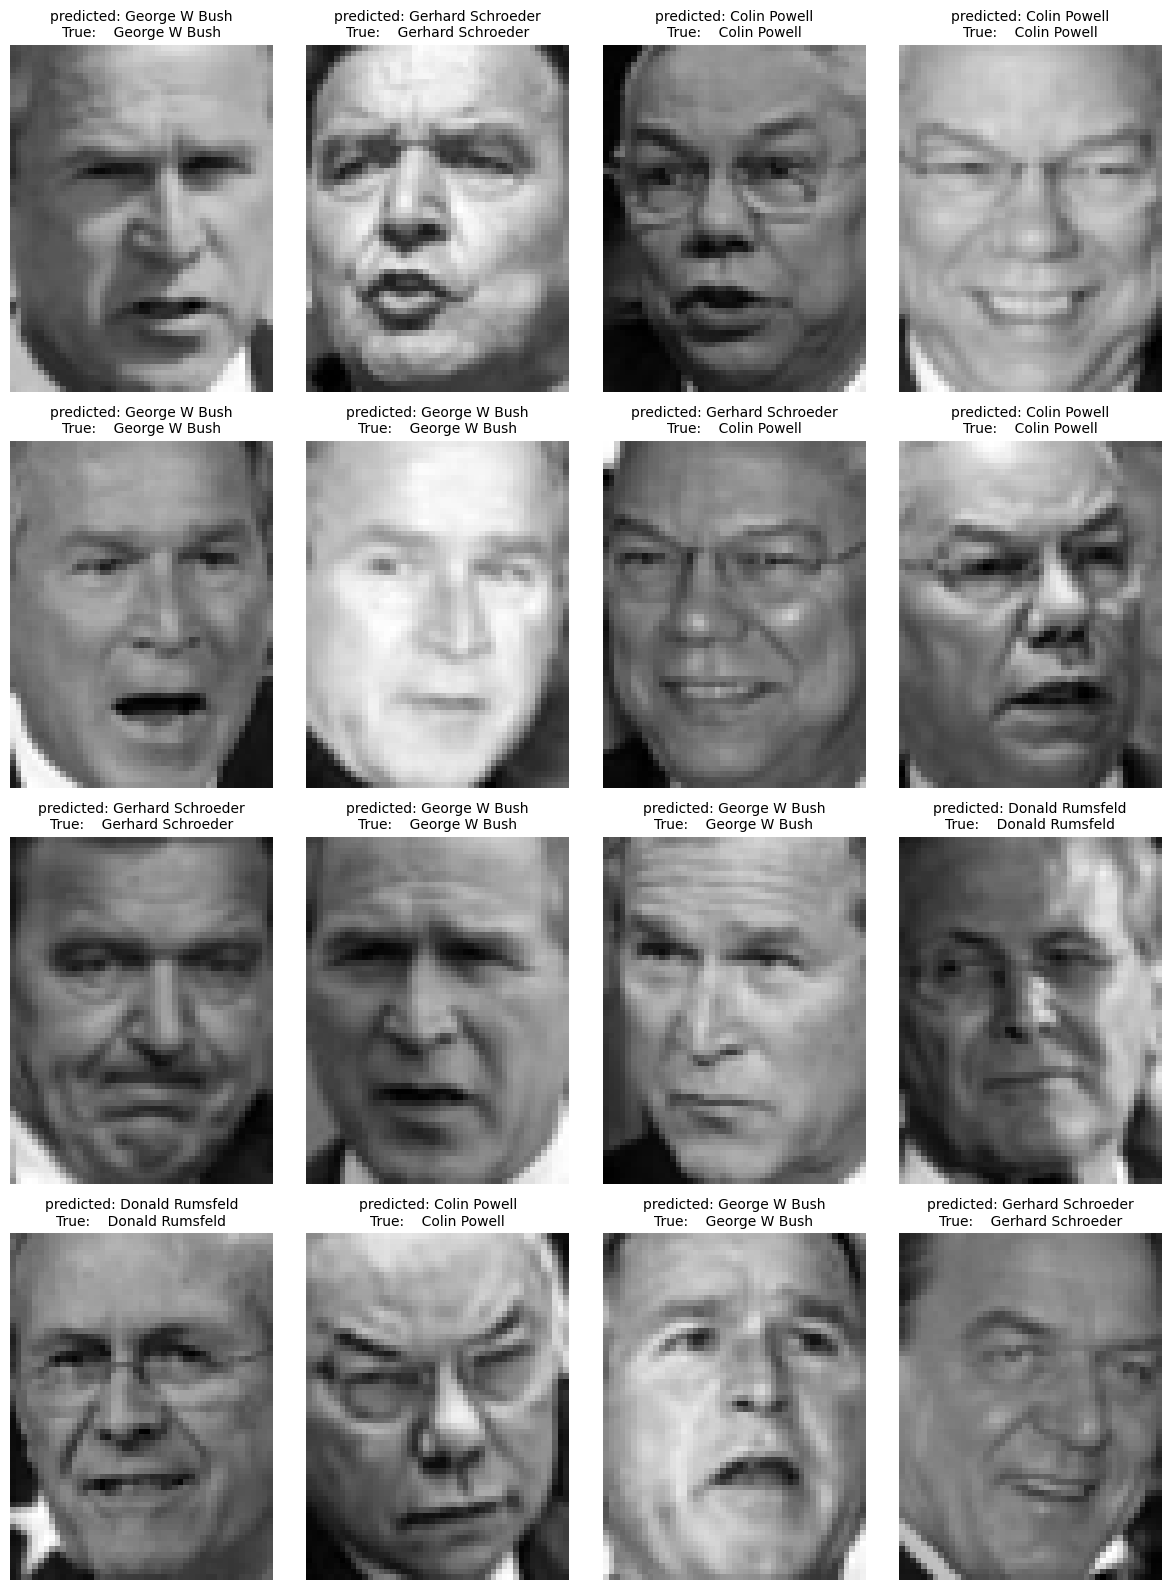

In [18]:
fig, axs = plt.subplots(4,4,figsize=(12,16))
for i in range(16):
    row = i // 4
    col = i % 4

    axs[row, col].imshow(x_test[i],cmap = 'gray')
    title = "Predicted: %s\nTrue:    %s" % (classes[predicted[i]], classes[y_test[i]])
    axs[row, col].set_title(title, fontsize=10)
    axs[row, col].axis('off')
plt.tight_layout()


Given Query image....


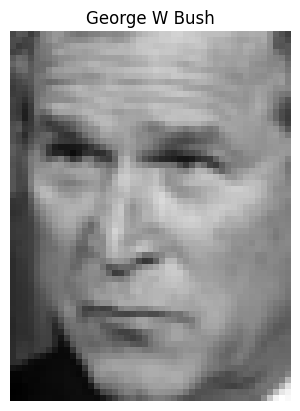

Visually similar images are.....


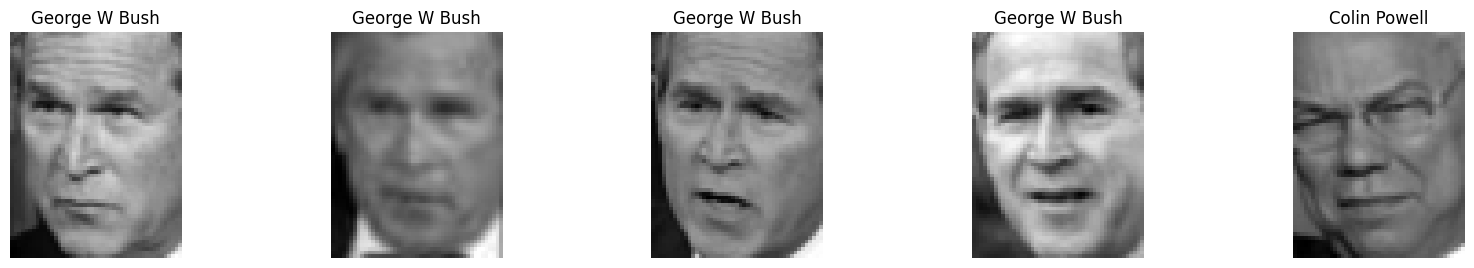

In [19]:
# Image retrieval using KNN 
# Given a query image , try to find visually similar images from an image database

from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(n_neighbors= 5,)
knn.fit(test_features)

def predict(testdata):
    
    res = []
    for i, data in enumerate(testdata):
        idx = knn.kneighbors(testdata[i].reshape(1,-1),return_distance= False)
        res.append((x_test[i],idx[0]))
    return res

res = predict(test_features)

test_img1, index_id = res[10]
plt.imshow(test_img1, cmap = 'gray')
print("Given Query image....")
plt.title(classes[y_test[10]])
plt.axis('off')
plt.show()
print("Visually similar images are.....")
plt.figure(figsize= (20,10))
for i, idx in enumerate(index_id):
    ax = plt.subplot(3,5,i+1+5)
    plt.imshow(x_test[idx], cmap = 'gray')
    ax.set_title(classes[y_test[idx]])
    ax.axis('off')